In [1]:
import sys
sys.path.append('../30_data_tools/')

In [2]:
import plotly.express as px
import json
from datetime import datetime
import pandas as pd

In [3]:
from file_interaction import download_blob, get_blobs
import plotly.graph_objects as go

In [4]:
available_experiments = get_blobs(filter='train_logs/')
available_experiments

['train_logs/2024-04-02_resnet50.json',
 'train_logs/2024-04-02_resnet50_001.json',
 'train_logs/2024-04-02_resnet50_002.json',
 'train_logs/2024-04-03_resnet50_001.json',
 'train_logs/2024-04-03_resnet50_002.json',
 'train_logs/2024-04-03_resnet50_003.json',
 'train_logs/2024-04-03_resnet50_004.json',
 'train_logs/2024-04-03_resnet50_005.json',
 'train_logs/2024-04-03_resnet50_006.json',
 'train_logs/2024-04-03_resnet50_007.json',
 'train_logs/2024-04-11_resnet50_001.json',
 'train_logs/2024-04-11_resnet50_002.json',
 'train_logs/2024-04-11_resnet50_003.json']

In [5]:
def load_experiment( experiment_name ):
    json_buffer = download_blob( f'train_logs/{ experiment_name }.json' )
    data = json.loads( json_buffer.getvalue() )
    data['start_timestamp'] = datetime.fromisoformat(data['start_timestamp'])

    if 'end_timestamp' in data:
        data['end_timestamp'] = datetime.fromisoformat(data['end_timestamp'])

    for t in data['tracked_metrics']:
        t['timestamp'] = datetime.fromisoformat(t['timestamp'])
        t['value'] = float(t['value'])
    
    return data

In [6]:
def get_figure( data, metric_name, mode ):
    fig = px.line(
        x=data.loc[(data.metric_name == metric_name) &  (data['mode'] == mode)].step,
        y=data.loc[(data.metric_name == metric_name) &  (data['mode'] == mode)].value,
        color=data.loc[(data.metric_name == metric_name) &  (data['mode'] == mode)].epoch
    )
    #fig.update_layout(yaxis_range=[0,1])
    
    return fig

In [80]:
experiment_name = '2024-04-11_resnet50_003'
experiment_data = load_experiment( experiment_name )
data = pd.DataFrame.from_dict(experiment_data['tracked_metrics'])

In [81]:
experiment_data['hyper_parameters']

{'epochs': 35,
 'learning_rate': 0.001,
 'batch_size': 64,
 'loss_function': 'CrossEntropyLoss',
 'metric_functions': ['MulticlassAccuracy',
  'MulticlassRecall',
  'MulticlassPrecision'],
 'optimizer': 'SGD',
 'device': 'cuda'}

In [82]:
rel_data_train = data.loc[data['mode'] == 'train'].copy()
rel_data_train.loc[:,'step_total'] = (rel_data_train.epoch - 1) * rel_data_train.step.max() + rel_data_train.step

grouped_train = rel_data_train.loc[
    :,
    ['metric_name','step_total','value']
].groupby(['metric_name','step_total']).first().unstack('metric_name')

grouped_train.columns = [c[1] for c in grouped_train.columns]

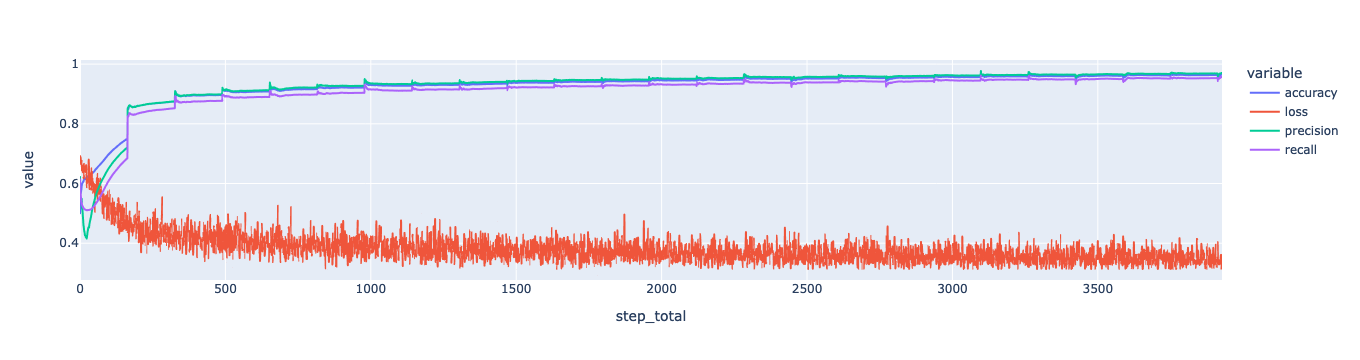

In [83]:
px.line(
    grouped_train
)

In [84]:
rel_data_val = data.loc[data['mode'] == 'val'].copy()
rel_data_val.loc[:,'step_total'] = (rel_data_val.epoch - 1) * rel_data_val.step.max() + rel_data_val.step

grouped_val = rel_data_val.loc[
    :,
    ['metric_name','step_total','value']
].groupby(['metric_name','step_total']).first().unstack('metric_name')

grouped_val.columns = [c[1] for c in grouped_val.columns]

In [85]:
(grouped_val.loss.iloc[-1] - grouped_val.loss.iloc[0]) / grouped_val.shape[0]

-0.00029387924528301887

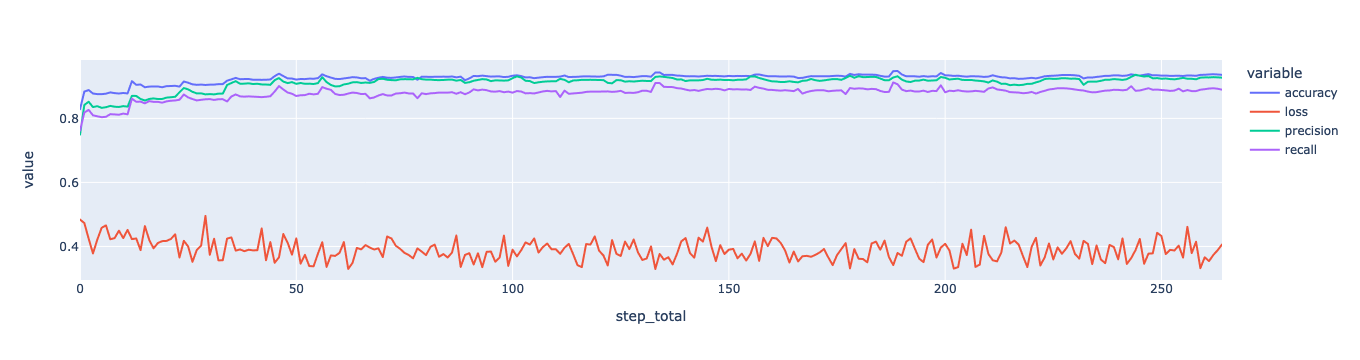

In [86]:
px.line(
    grouped_val
)

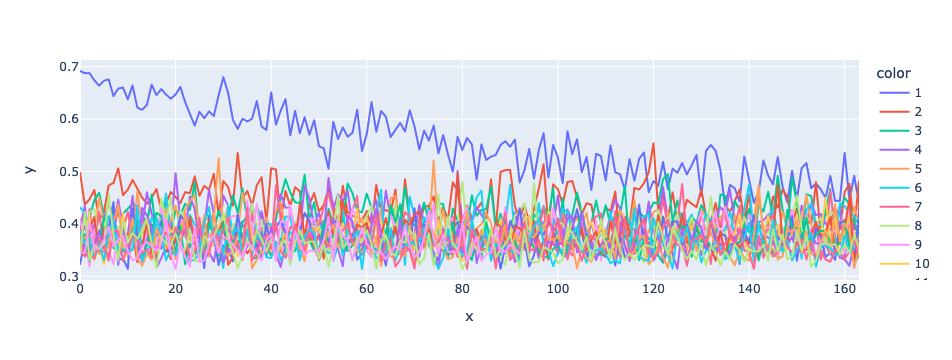

In [29]:
get_figure(
    data,
    'loss',
    'train'
)

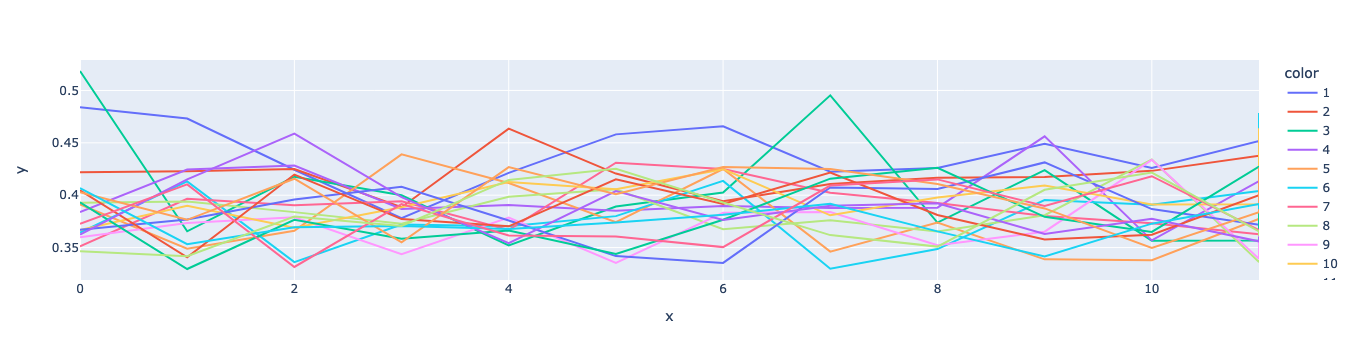

In [30]:
get_figure(
    data,
    'loss',
    'val'
)

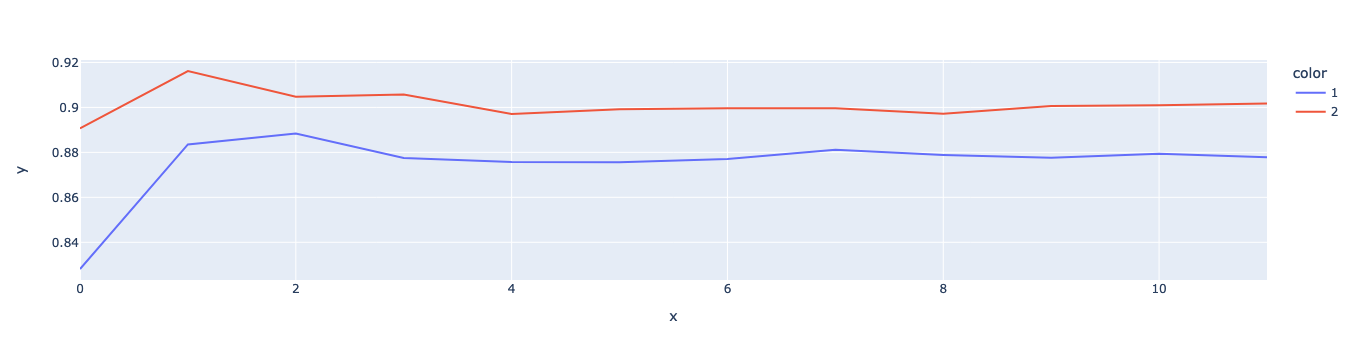

In [17]:
get_figure(
    data,
    'accuracy',
    'val'
)

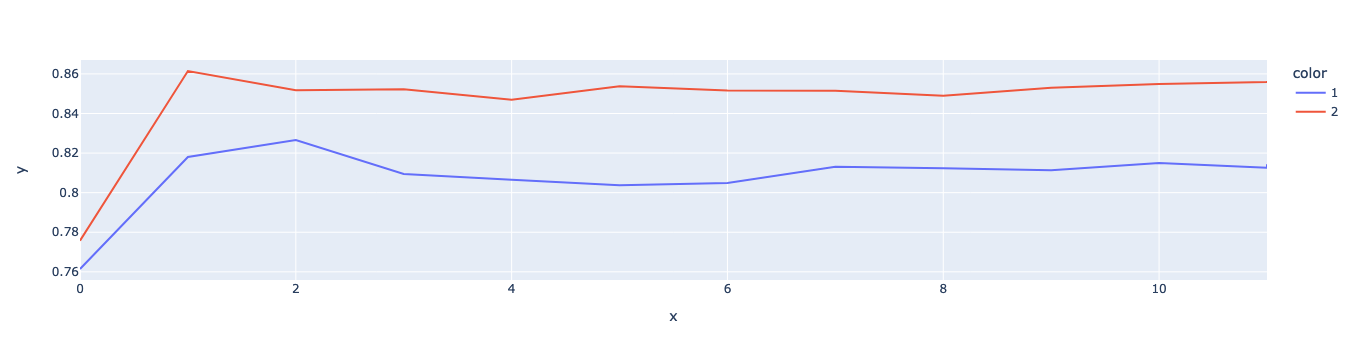

In [16]:
get_figure(
    data,
    'recall',
    'val'
)